In [1]:
import torch
import torchvision

In [14]:
n_epochs = 10
batch_size_train = 512
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [16]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

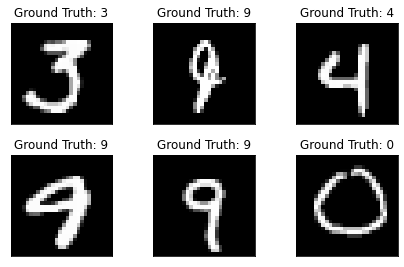

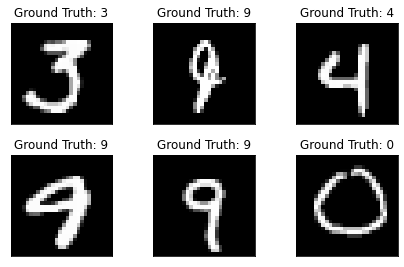

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.tns1 = nn.Conv2d(in_channels=128, out_channels=4, kernel_size=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=32)
       
        self.pool2 = nn.MaxPool2d(2, 2)
        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16,kernel_size=1, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(num_features=32)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=1)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        self.drop = nn.Dropout2d(0.1)
    def forward(self, x):
        x = self.tns1(self.drop(self.bn1(F.relu(self.conv1(x)))))
        x = self.drop(self.bn2(F.relu(self.conv2(x))))
        x = self.pool1(x)
        x = self.drop(self.bn3(F.relu(self.conv3(x))))
        x = self.drop(self.bn4(F.relu(self.conv4(x))))
        x = self.tns2(self.pool2(x))
        x = self.drop(self.bn5(F.relu(self.conv5(x))))
        x = self.drop(self.bn6(F.relu(self.conv6(x))))
        x = self.conv7(x)
        x = self.gpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)        

In [9]:
dev='cuda:0'
network = Net()
network.to(dev)
optimizer = optim.SGD(network.parameters(), lr=0.01,
                      momentum=momentum)
#network.load_state_dict(torch.load('results/model.pth'))

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(dev)
    target=target.to(dev)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')




In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.to(dev)
      target=target.to(dev)
      output = network(data)
      test_loss += F.nll_loss(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [18]:
n_epochs = 200
#test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()      

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.956486
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.770735

Test set: Avg. loss: 0.0006, Accuracy: 8914/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.757789
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.587362

Test set: Avg. loss: 0.0004, Accuracy: 9129/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.585773
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.524321

Test set: Avg. loss: 0.0003, Accuracy: 9226/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.541608
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.433795

Test set: Avg. loss: 0.0003, Accuracy: 9360/10000 (94%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.447275
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.417057

Test set: Avg. loss: 0.0002, Accuracy: 9399/10000 (94%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.318740
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.337203

Test set: Avg. loss: 0.0002, Accuracy: 9501/10000 (95%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.315115
Train Epoch: 7 [51200/60000 (85%)]	Lo

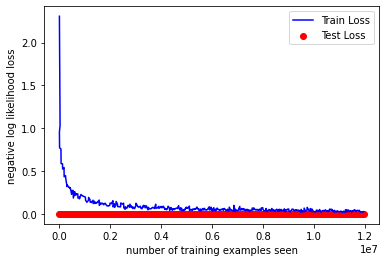

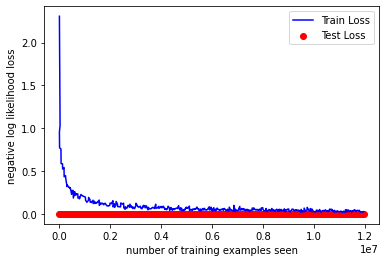

In [28]:
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [21]:
torch.save(network.state_dict(), 'results/model.pth')
torch.save(optimizer.state_dict(), 'results/optimizer.pth')
